[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

Patch extraction is a crucial step in the processing of data by transformers. It involves dividing the input, be it an image or another form of data, into smaller segments known as patches. These patches capture specific local information, like texture, edges, and colors, which are essential for the transformer model's understanding.

In computer vision, patch extraction specifically refers to dividing an image into fixed-size patches. This division allows transformers to process the image in parallel, with each patch containing valuable visual details. By analyzing patches independently, transformers can efficiently utilize computational resources and memory, making it feasible to handle large images that would otherwise be computationally burdensome to process as a whole.

Patch extraction has demonstrated its effectiveness across various computer vision tasks, including image classification, object detection, and image generation. This technique enables transformers to effectively capture both local and global visual features, facilitating accurate predictions and meaningful representations.



#### Library Imports

In [30]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers

#### Auxiliar functions
Check the docstrings for more information.

In [31]:
def read_data(path_list, im_size=(224,224)):
    """
    Given the list of paths where the images are stored <path_list>,
    and the size for image decimation <im_size>, it returns 2 Numpy Arrays
    with the images and labels; and a dictionary with the mapping between
    classes and folders. This will be used later for displaying the predicted
    labels.

        Parameters:
            path_list (List[String]): The list of paths to the images.
            im_size (Tuple): The height and width values.

        Returns:
            X (ndarray): Images
            y (ndarray): Labels
            tag2idx (dict): Map between labels and folders.
    """

    X = []
    y = []
    
    # Exctract the file-names of the datasets we read and create a label dictionary. 
    tag2idx = {tag.split(os.path.sep)[-1]:i for i, tag in enumerate(path_list)}
    
    for path in path_list:
        for im_file in tqdm(glob(path + '*/*')): # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-2] 
                im = cv2.imread(im_file, cv2.IMREAD_COLOR) 
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                #im = quantize_image(im)
                im = cv2.resize(im, im_size,interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])# Append the label name to y 
            except Exception as e:
                # In case annotations or metadata are found
                print("Not a picture")
    
    X = np.array(X) # Convert list to numpy array.
    y = np.array(y).astype(np.uint8)
    
    return X, y

In [32]:
class PatchExtractor(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

#### Experimental Constants

In [33]:
INPUT_SHAPE = (224, 224, 3)
IM_SIZE = (224, 224)
PATCH_SIZE = 12
# Datasets' paths we want to work on.
PATH_LIST = ["eden_library_datasets/Black nightsade-Solanum nigrum-220519-Weed-zz"]

#### Loading images and Data Loaders

In [34]:
i=0
for path in PATH_LIST:
    #Define paths in an OS agnostic way.
    PATH_LIST[i] = str(Path(Path.cwd()).parents[0].joinpath(path)) 
    i+=1
X, y = read_data(PATH_LIST, IM_SIZE)

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 105/124 [00:24<00:04,  4.23it/s]

Not a picture


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:28<00:00,  4.29it/s]


#### Patching a random sample image

In [36]:
sample_image = X[np.random.choice(range(0, X.shape[0]))]

In [37]:
tensor_image = tf.convert_to_tensor([sample_image])

In [38]:
patches = PatchExtractor(PATCH_SIZE)(tensor_image)

In [39]:
n = int(np.sqrt(patches.shape[1]))

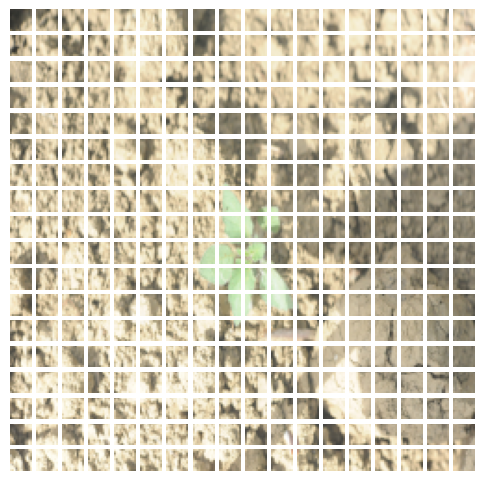

In [40]:
plt.figure(figsize=(6, 6))
for i, patch in enumerate(patches[0]):
    plt.subplot(n, n, i+1)
    patch_img = tf.reshape(patch, [PATCH_SIZE, PATCH_SIZE, 3])
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")
plt.show()

## Possible Extensions
1. Change the Patch Size.
2. Try different images.